In [1]:
%cd /home/thucth/thucth/project/insightface/recognition/arcface_torch

/home/thucth/thucth/project/insightface/recognition/arcface_torch


## Convert Arcface into AdaFace heads

In [340]:
# Dummy input/labels
embs = torch.randn(2,512)
norm = torch.norm(embs,2,dim=-1,keepdim=True)
embs = torch.div(embs, norm)
labels = torch.tensor([6,9])
print("embs.shape: ",embs.shape) 
print("norm.shape: ",norm.shape) 
print("labels.shape: ",labels.shape) 

embs.shape:  torch.Size([2, 512])
norm.shape:  torch.Size([2, 1])
labels.shape:  torch.Size([2])


In [ ]:
import torch
import math
from torch.nn import CrossEntropyLoss


def l2_norm(input,axis=-1):
    norm = torch.norm(input,2,axis,True)
    output = torch.div(input, norm)
    return output
class AdaFaceWAct(torch.nn.Module):
    ''' 
    1. Multiply embeddings with W (W phase)
    2. Compute Adaface Activate (like normalized softmax) (Act phase)
    '''
    def __init__(self,
                 embedding_size=512,
                 classnum=70722,
                 m=0.4,
                 h=0.333,
                 s=64.,
                 t_alpha=1.0,
                 ):
        super(AdaFaceWAct, self).__init__()
        self.classnum = classnum
        self.kernel = torch.nn.Parameter(torch.Tensor(embedding_size,classnum))
        # # initial kernel
        self.kernel.data.uniform_(-1, 1).renorm_(2,1,1e-5).mul_(1e5)
        # self.kernel = torch.nn.Parameter(torch.ones(embedding_size,classnum)) for debug without randomness

        self.m = m 
        self.eps = 1e-3
        self.h = h
        self.s = s

        # ema prep
        self.t_alpha = t_alpha
        self.register_buffer('t', torch.zeros(1))
        self.register_buffer('batch_mean', torch.ones(1)*(20))
        self.register_buffer('batch_std', torch.ones(1)*100)

        print('\n\AdaFaceWAct with the following property')
        print('self.m', self.m)
        print('self.h', self.h)
        print('self.s', self.s)
        print('self.t_alpha', self.t_alpha)

    def forward(self, embbedings, norms, label):
        kernel_norm = l2_norm(self.kernel,axis=0)
        print(kernel_norm)
        cosine = torch.mm(embbedings,kernel_norm)
        cosine = cosine.clamp(-1+self.eps, 1-self.eps) # for stability
        
        print(cosine)
        
        safe_norms = torch.clip(norms, min=0.001, max=100) # for stability
        safe_norms = safe_norms.clone().detach()

        # update batchmean batchstd
        with torch.no_grad():
            mean = safe_norms.mean().detach()
            std = safe_norms.std().detach()
            self.batch_mean = mean * self.t_alpha + (1 - self.t_alpha) * self.batch_mean
            self.batch_std =  std * self.t_alpha + (1 - self.t_alpha) * self.batch_std

        margin_scaler = (safe_norms - self.batch_mean) / (self.batch_std+self.eps) # 66% between -1, 1
        margin_scaler = margin_scaler * self.h # 68% between -0.333 ,0.333 when h:0.333
        margin_scaler = torch.clip(margin_scaler, -1, 1)
        # ex: m=0.5, h:0.333
        # range
        #       (66% range)
        #   -1 -0.333  0.333   1  (margin_scaler)
        # -0.5 -0.166  0.166 0.5  (m * margin_scaler)

        # g_angular
        m_arc = torch.zeros(label.size()[0], cosine.size()[1], device=cosine.device)
        m_arc.scatter_(1, label.reshape(-1, 1), 1.0)
        g_angular = self.m * margin_scaler * -1
        m_arc = m_arc * g_angular
        theta = cosine.acos()
        theta_m = torch.clip(theta + m_arc, min=self.eps, max=math.pi-self.eps)
        cosine = theta_m.cos()

        # g_additive
        m_cos = torch.zeros(label.size()[0], cosine.size()[1], device=cosine.device)
        m_cos.scatter_(1, label.reshape(-1, 1), 1.0)
        g_add = self.m + (self.m * margin_scaler)
        m_cos = m_cos * g_add
        cosine = cosine - m_cos
        # scale
        scaled_cosine_m = cosine * self.s
        return scaled_cosine_m

cross_entropy_loss = CrossEntropyLoss()

adaface_w_act = AdaFaceWAct(embedding_size=512,
                 classnum=10,
                 m=0.4,
                 h=0.333,
                 s=64.,
                 t_alpha=1.0)

logits = adaface_w_act(embs,norm,labels)

loss_train = cross_entropy_loss(logits, labels)
print(loss_train)

## Seperate W and Act

In [ ]:
from typing import Callable

def l2_norm(input,axis=-1):
    norm = torch.norm(input,2,axis,True)
    output = torch.div(input, norm)
    return output
    
class AdaFC(torch.nn.Module):
    ''' 
    1. Multiply embeddings with W (FC phase)
    2. Compute Adaface Activate (like normalized softmax) (Act phase)
    '''
    def __init__(self,
                 margin_loss: Callable,
                 embedding_size=512,
                 classnum=70722,
                 ):
        super(AdaFC, self).__init__()
        self.classnum = classnum
        self.kernel = torch.nn.Parameter(torch.Tensor(embedding_size,classnum))
        self.kernel.data.uniform_(-1, 1).renorm_(2,1,1e-5).mul_(1e5)
        # self.kernel = torch.nn.Parameter(torch.ones(embedding_size,classnum)) for debug without randomness

        self.dist_cross_entropy = CrossEntropyLoss()

        # margin_loss
        if isinstance(margin_loss, Callable):
            self.margin_softmax = margin_loss
        else:
            raise

        # initial kernel
        self.eps = 1e-3

    def forward(self, embbedings, norms, labels):
        kernel_norm = l2_norm(self.kernel,axis=0)
        print(kernel_norm)
        logits = torch.mm(embbedings,kernel_norm)
        logits = logits.clamp(-1+self.eps, 1-self.eps) # for stability
        print(logits)
        logits = self.margin_softmax(logits,norms, labels)
        loss = self.dist_cross_entropy(logits, labels)
        return loss

class AdaAct(torch.nn.Module):
    ''' 
    This version is modified as ArcFace method
    1. Multiply embeddings with W (FC phase)
    2. Compute Adaface Activate (like normalized softmax) (Act phase)
    '''
    def __init__(self,
                 m=0.4,
                 h=0.333,
                 s=64.,
                 t_alpha=1.0,
                 ):
        super(AdaAct, self).__init__()
        self.m = m 
        self.eps = 1e-3
        self.h = h
        self.s = s
        
        # ema prep
        self.t_alpha = t_alpha
        self.register_buffer('batch_mean_z', torch.ones(1)*(20))
        self.register_buffer('batch_std_z', torch.ones(1)*100)

        print('\n\AdaFaceWAct with the following property')
        print('self.m', self.m)
        print('self.h', self.h)
        print('self.s', self.s)
        print('self.t_alpha', self.t_alpha)

    def forward(self, logits:torch.Tensor, norms:torch.Tensor, labels:torch.Tensor):

        logits = logits.clamp(-1+self.eps, 1-self.eps) # for stability
        
        safe_norms = torch.clip(norms, min=0.001, max=100) # for stability
        safe_norms = safe_norms.clone().detach()

        # update batchmean batchstd
        with torch.no_grad():
            mean_z = safe_norms.mean().detach()
            std_z = safe_norms.std().detach()
            self.batch_mean_z = mean_z * self.t_alpha + (1 - self.t_alpha) * self.batch_mean_z
            self.batch_std_z =  std_z * self.t_alpha + (1 - self.t_alpha) * self.batch_std_z


        z = (safe_norms - self.batch_mean_z) / (self.batch_std_z+self.eps)
        z = z * self.h 
        z = torch.clip(z, -1, 1)

        # g_angular shape(2,1)
        g_angular = - self.m * z 
        g_angular = g_angular.reshape(-1)
        
        index = torch.where(labels != -1)[0]
        target_logits = logits[index, labels[index].view(-1)]
        print(target_logits)
        theta = target_logits.acos()
        theta_m = torch.clip(theta + g_angular, min=self.eps, max=math.pi-self.eps)######
        target_logits_angular = theta_m.cos()

        # g_additive sahpe(2,1)
        g_add = self.m + (self.m * z)
        g_add = g_add.reshape(-1)
        target_logits_add = target_logits_angular - g_add
        # this is not easy_marin in arcface
        gap_ = 1 - self.m*z - self.m - (self.m*z).cos()
        gap_ = gap_.reshape(-1)

        final_target_logits = torch.where(theta + g_angular > 0, target_logits_add, target_logits+gap_)

        logits[index, labels[index].view(-1)] = final_target_logits
        logits = logits * self.s
        return logits

class AdaActOrigin(torch.nn.Module):
    ''' 
    This version is modified as Ogirinal ArcFace 
    1. Multiply embeddings with W (FC phase)
    2. Compute Adaface Activate (like normalized softmax) (Act phase)
    '''
    def __init__(self,
                 m=0.4,
                 h=0.333,
                 s=64.,
                 t_alpha=1.0,
                 ):
        super(AdaActOrigin, self).__init__()
        self.m = m 
        self.eps = 1e-3
        self.h = h
        self.s = s
        
        # ema prep
        self.t_alpha = t_alpha
        self.register_buffer('batch_mean_z', torch.ones(1)*(20))
        self.register_buffer('batch_std_z', torch.ones(1)*100)

        print('\n\AdaFaceWAct with the following property')
        print('self.m', self.m)
        print('self.h', self.h)
        print('self.s', self.s)
        print('self.t_alpha', self.t_alpha)

    def forward(self, logits:torch.Tensor, norms:torch.Tensor, labels:torch.Tensor):
        logits = logits.clamp(-1+self.eps, 1-self.eps) # for stability
        
        safe_norms = torch.clip(norms, min=0.001, max=100) # for stability
        safe_norms = safe_norms.clone().detach()

        # update batchmean batchstd
        with torch.no_grad():
            mean_z = safe_norms.mean().detach()
            std_z = safe_norms.std().detach()
            self.batch_mean_z = mean_z * self.t_alpha + (1 - self.t_alpha) * self.batch_mean_z
            self.batch_std_z =  std_z * self.t_alpha + (1 - self.t_alpha) * self.batch_std_z


        margin_scaler = (safe_norms - self.batch_mean_z) / (self.batch_std_z+self.eps) # 66% between -1, 1
        margin_scaler = margin_scaler * self.h # 68% between -0.333 ,0.333 when h:0.333
        margin_scaler = torch.clip(margin_scaler, -1, 1)
        # ex: m=0.5, h:0.333
        # range
        #       (66% range)
        #   -1 -0.333  0.333   1  (margin_scaler)
        # -0.5 -0.166  0.166 0.5  (m * margin_scaler)

        # g_angular
        m_arc = torch.zeros(labels.size()[0], logits.size()[1], device=logits.device)
        m_arc.scatter_(1, labels.reshape(-1, 1), 1.0)
        g_angular = self.m * margin_scaler * -1
        m_arc = m_arc * g_angular
        theta = logits.acos()
        theta_m = torch.clip(theta + m_arc, min=self.eps, max=math.pi-self.eps)
        logits = theta_m.cos()

        # g_additive
        m_cos = torch.zeros(labels.size()[0], logits.size()[1], device=logits.device)
        m_cos.scatter_(1, labels.reshape(-1, 1), 1.0)
        g_add = self.m + (self.m * margin_scaler)
        m_cos = m_cos * g_add
        logits = logits - m_cos

        # scale
        scaled_logits_m = logits * self.s
        return scaled_logits_m


ada_act = AdaAct(m=0.4, h=0.333, s=64., t_alpha=1.0)
# ada_act = AdaActOrigin(m=0.4, h=0.333, s=64., t_alpha=1.0)
ada_fc = AdaFC(margin_loss=ada_act, embedding_size=512, classnum=10)

loss = ada_fc(embs, norm, labels)
print(loss)


# Partial Ada FC

In [317]:
import os
try:
    world_size = int(os.environ["WORLD_SIZE"])
    rank = int(os.environ["RANK"])
    distributed.init_process_group("nccl")
except KeyError:
    world_size = 1
    rank = 0
    distributed.init_process_group(
        backend="nccl",
        init_method="tcp://127.0.0.1:12584",
        rank=rank,
        world_size=world_size,
    )


In [343]:
import collections
from typing import Callable

import torch
from torch import distributed
from torch.nn.functional import linear, normalize

class AllGatherFunc(torch.autograd.Function):
    """AllGather op with gradient backward"""

    @staticmethod
    def forward(ctx, tensor, *gather_list):
        gather_list = list(gather_list)
        distributed.all_gather(gather_list, tensor)
        return tuple(gather_list)

    @staticmethod
    def backward(ctx, *grads):
        grad_list = list(grads)
        rank = distributed.get_rank()
        grad_out = grad_list[rank]

        dist_ops = [
            distributed.reduce(grad_out, rank, distributed.ReduceOp.SUM, async_op=True)
            if i == rank
            else distributed.reduce(
                grad_list[i], i, distributed.ReduceOp.SUM, async_op=True
            )
            for i in range(distributed.get_world_size())
        ]
        for _op in dist_ops:
            _op.wait()

        grad_out *= len(grad_list)  # cooperate with distributed loss function
        return (grad_out, *[None for _ in range(len(grad_list))])

AllGather = AllGatherFunc.apply

class DistCrossEntropyFunc(torch.autograd.Function):
    """
    CrossEntropy loss is calculated in parallel, allreduce denominator into single gpu and calculate softmax.
    Implemented of ArcFace (https://arxiv.org/pdf/1801.07698v1.pdf):
    """

    @staticmethod
    def forward(ctx, logits: torch.Tensor, label: torch.Tensor):
        """ """
        batch_size = logits.size(0)
        # for numerical stability
        max_logits, _ = torch.max(logits, dim=1, keepdim=True)
        # local to global
        distributed.all_reduce(max_logits, distributed.ReduceOp.MAX)
        logits.sub_(max_logits)
        logits.exp_()
        sum_logits_exp = torch.sum(logits, dim=1, keepdim=True)
        # local to global
        distributed.all_reduce(sum_logits_exp, distributed.ReduceOp.SUM)
        logits.div_(sum_logits_exp)
        index = torch.where(label != -1)[0]
        # loss
        loss = torch.zeros(batch_size, 1, device=logits.device)
        loss[index] = logits[index].gather(1, label[index])
        distributed.all_reduce(loss, distributed.ReduceOp.SUM)
        ctx.save_for_backward(index, logits, label)
        return loss.clamp_min_(1e-30).log_().mean() * (-1)

    @staticmethod
    def backward(ctx, loss_gradient):
        """
        Args:
            loss_grad (torch.Tensor): gradient backward by last layer
        Returns:
            gradients for each input in forward function
            `None` gradients for one-hot label
        """
        (
            index,
            logits,
            label,
        ) = ctx.saved_tensors
        batch_size = logits.size(0)
        one_hot = torch.zeros(
            size=[index.size(0), logits.size(1)], device=logits.device
        )
        one_hot.scatter_(1, label[index], 1)
        logits[index] -= one_hot
        logits.div_(batch_size)
        return logits * loss_gradient.item(), None

class DistCrossEntropy(torch.nn.Module):
    def __init__(self):
        super(DistCrossEntropy, self).__init__()

    def forward(self, logit_part, label_part):
        return DistCrossEntropyFunc.apply(logit_part, label_part)

class AdaPartialFC(torch.nn.Module):
    """
    https://arxiv.org/abs/2203.15565
    A distributed sparsely updating variant of the FC layer, named Partial FC (PFC).

    When sample rate less than 1, in each iteration, positive class centers and a random subset of
    negative class centers are selected to compute the margin-based softmax loss, all class
    centers are still maintained throughout the whole training process, but only a subset is
    selected and updated in each iteration.

    .. note::
        When sample rate equal to 1, Partial FC is equal to model parallelism(default sample rate is 1).

    Example:
    --------
    >>> module_pfc = AdaPartialFC(embedding_size=512, num_classes=8000000, sample_rate=0.2)
    >>> for img, labels in data_loader:
    >>>     embeddings = net(img)
    >>>     loss = module_pfc(embeddings, labels, optimizer)
    >>>     loss.backward()
    >>>     optimizer.step()
    """
    _version = 1 
    def __init__(
        self,
        margin_loss: Callable,
        embedding_size: int,
        num_classes: int,
        sample_rate: float = 1.0,
        fp16: bool = False,
    ):
        """
        Paramenters:
        -----------
        embedding_size: int
            The dimension of embedding, required
        num_classes: int
            Total number of classes, required
        sample_rate: float
            The rate of negative centers participating in the calculation, default is 1.0.
        """
        super(AdaPartialFC, self).__init__()
        assert (
            distributed.is_initialized()
        ), "must initialize distributed before create this"
        self.rank = distributed.get_rank()
        self.world_size = distributed.get_world_size()

        self.dist_cross_entropy = DistCrossEntropy()
        self.embedding_size = embedding_size
        self.sample_rate: float = sample_rate
        self.fp16 = fp16
        self.num_local: int = num_classes // self.world_size + int(
            self.rank < num_classes % self.world_size
        )
        self.class_start: int = num_classes // self.world_size * self.rank + min(
            self.rank, num_classes % self.world_size
        )
        self.num_sample: int = int(self.sample_rate * self.num_local)
        self.last_batch_size: int = 0
        self.weight: torch.Tensor
        self.weight_mom: torch.Tensor
        self.weight_activated: torch.nn.Parameter
        self.weight_activated_mom: torch.Tensor
        self.is_updated: bool = True
        self.init_weight_update: bool = True

        self.weight_activated = torch.nn.Parameter(torch.normal(0, 0.01, (self.num_local, embedding_size)))

        # margin_loss
        if isinstance(margin_loss, Callable):
            self.margin_softmax = margin_loss
        else:
            raise

    @torch.no_grad()
    def update(self):
        """ partial weight to global
        """
        if self.init_weight_update:
            self.init_weight_update = False
            return

    def forward(
        self,
        local_embeddings: torch.Tensor,
        norms:torch.Tensor,
        local_labels: torch.Tensor
    ):
        """
        Parameters:
        ----------
        local_embeddings: torch.Tensor
            feature embeddings on each GPU(Rank).
        local_labels: torch.Tensor
            labels on each GPU(Rank).

        Returns:
        -------
        loss: torch.Tensor
            pass
        """

        local_labels.squeeze_()
        local_labels = local_labels.long()
        self.update()

        batch_size = local_embeddings.size(0)
        if self.last_batch_size == 0:
            self.last_batch_size = batch_size
        assert self.last_batch_size == batch_size, (
            "last batch size do not equal current batch size: {} vs {}".format(
            self.last_batch_size, batch_size))

        _gather_embeddings = [
            torch.zeros((batch_size, self.embedding_size)).cuda()
            for _ in range(self.world_size)
        ]
        _gather_labels = [
            torch.zeros(batch_size).long().cuda() for _ in range(self.world_size)
        ]
        _list_embeddings = AllGather(local_embeddings, *_gather_embeddings)
        distributed.all_gather(_gather_labels, local_labels)

        embeddings = torch.cat(_list_embeddings)
        labels = torch.cat(_gather_labels)

        labels = labels.view(-1, 1)
        index_positive = (self.class_start <= labels) & (
            labels < self.class_start + self.num_local
        )
        labels[~index_positive] = -1
        labels[index_positive] -= self.class_start
        with torch.cuda.amp.autocast(self.fp16):
            norm_embeddings = normalize(embeddings)
            norm_weight_activated = normalize(self.weight_activated)
            logits = linear(norm_embeddings, norm_weight_activated)
        if self.fp16:
            logits = logits.float()
        logits = logits.clamp(-1, 1)
        logits = self.margin_softmax(logits, norms, labels)
        loss = self.dist_cross_entropy(logits, labels)
        return loss

    def state_dict(self, destination=None, prefix="", keep_vars=False):
        if destination is None: 
            destination = collections.OrderedDict()
            destination._metadata = collections.OrderedDict()

        for name, module in self._modules.items():
            if module is not None:
                module.state_dict(destination, prefix + name + ".", keep_vars=keep_vars)
        if self.sample_rate < 1:
            destination["weight"] = self.weight.detach()
        else:
            destination["weight"] = self.weight_activated.data.detach()
        return destination


        

In [ ]:
ada_act = AdaAct(m=0.4, h=0.333, s=64., t_alpha=1.0)
# ada_act = AdaActOrigin(m=0.4, h=0.333, s=64., t_alpha=1.0)
ada_fc = AdaPartialFC(margin_loss=ada_act, embedding_size=512, num_classes=10)
ada_fc.cuda()
loss = ada_fc(embs.cuda(), norm.cuda(), labels.cuda())
print(loss)

# MxFaceDataset to remove failed samples

In [3]:
# from dataset import MXFaceDataset
import mxnet as mx
import os
import numpy as np
from tqdm import tqdm
import torch


/home/thucth/.conda/envs/torch19/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import numbers
import os
import queue as Queue
import threading
from typing import Iterable

import mxnet as mx
import numpy as np
import torch
from functools import partial
from torch import distributed
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder

class MXFaceDataset(Dataset):
    def __init__(self, root_dir, local_rank):
        super(MXFaceDataset, self).__init__()
        self.transform = transforms.Compose(
            [transforms.ToPILImage(),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
             ])
        self.root_dir = root_dir
        self.local_rank = local_rank
        path_imgrec = os.path.join(root_dir, 'train.rec')
        path_imgidx = os.path.join(root_dir, 'train.idx')
        self.imgrec = mx.recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, 'r')
        # from debug import ForkedPdb
        # ForkedPdb().set_trace()
        if "webface" in root_dir.lower():
            self.imgidx = np.array(list(self.imgrec.keys))
        else:
            s = self.imgrec.read_idx(0)
            header, _ = mx.recordio.unpack(s)
            if header.flag > 0:
                self.header0 = (int(header.label[0]), int(header.label[1]))
                self.imgidx = np.array(range(1, int(header.label[0])))
            else:
                self.imgidx = np.array(list(self.imgrec.keys))

    def __getitem__(self, index):
        idx = self.imgidx[index]
        s = self.imgrec.read_idx(idx)
        header, img = mx.recordio.unpack(s)
        label = header.label
        if not isinstance(label, numbers.Number):
            label = label[0]
        label = torch.tensor(label, dtype=torch.long)
        sample = mx.image.imdecode(img).asnumpy()
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, label

    def __len__(self):
        return len(self.imgidx)

In [24]:
# root_dir = "/mnt/data/WebFace42M_shufrec"
root_dir = "/mnt/data/MS1MV2"
# root_dir = "/mnt/data/WebFace_demo"


path_imgrec = os.path.join(root_dir, 'train.rec')
path_imgidx = os.path.join(root_dir, 'train.idx')

# Mxnet RecordIO
train_set = MXFaceDataset(root_dir=root_dir, local_rank=0)

In [10]:
class BackgroundGenerator(threading.Thread):
    def __init__(self, generator, local_rank, max_prefetch=6):
        super(BackgroundGenerator, self).__init__()
        self.queue = Queue.Queue(max_prefetch)
        self.generator = generator
        self.local_rank = local_rank
        self.daemon = True
        self.start()

    def run(self):
        torch.cuda.set_device(self.local_rank)
        for item in self.generator:
            self.queue.put(item)
        self.queue.put(None)

    def next(self):
        next_item = self.queue.get()
        if next_item is None:
            raise StopIteration
        return next_item

    def __next__(self):
        return self.next()

    def __iter__(self):
        return self

class DataLoaderX(DataLoader):

    def __init__(self, local_rank, **kwargs):
        super(DataLoaderX, self).__init__(**kwargs)
        self.stream = torch.cuda.Stream(local_rank)
        self.local_rank = local_rank

    def __iter__(self):
        self.iter = super(DataLoaderX, self).__iter__()
        self.iter = BackgroundGenerator(self.iter, self.local_rank)
        self.preload()
        return self

    def preload(self):
        self.batch = next(self.iter, None)
        if self.batch is None:
            return None
        with torch.cuda.stream(self.stream):
            for k in range(len(self.batch)):
                self.batch[k] = self.batch[k].to(device=self.local_rank, non_blocking=True)

    def __next__(self):
        torch.cuda.current_stream().wait_stream(self.stream)
        batch = self.batch
        if batch is None:
            raise StopIteration
        self.preload()
        return batch


In [17]:
from torch.utils.data import DistributedSampler as _DistributedSampler

class DistributedSampler(_DistributedSampler):
    def __init__(
        self,
        dataset,
        num_replicas=None,  # world_size
        rank=None,  # local_rank
        shuffle=True,
        seed=0,
    ):

        super().__init__(dataset, num_replicas=num_replicas, rank=rank, shuffle=shuffle)

        # In distributed sampling, different ranks should sample
        # non-overlapped data in the dataset. Therefore, this function
        # is used to make sure that each rank shuffles the data indices
        # in the same order based on the same seed. Then different ranks
        # could use different indices to select non-overlapped data from the
        # same data list.
        self.seed = 1101

    def __iter__(self):
        # deterministically shuffle based on epoch
        if self.shuffle:
            g = torch.Generator()
            # When :attr:`shuffle=True`, this ensures all replicas
            # use a different random ordering for each epoch.
            # Otherwise, the next iteration of this sampler will
            # yield the same ordering.
            g.manual_seed(self.epoch + self.seed)
            indices = torch.randperm(len(self.dataset), generator=g).tolist()
        else:
            indices = torch.arange(len(self.dataset)).tolist()

        # add extra samples to make it evenly divisible
        # in case that indices is shorter than half of total_size
        indices = (indices * math.ceil(self.total_size / len(indices)))[
            : self.total_size
        ]
        assert len(indices) == self.total_size

        # subsample
        indices = indices[self.rank : self.total_size : self.num_replicas]
        assert len(indices) == self.num_samples

        return iter(indices)


In [20]:
train_sampler = DistributedSampler(
    train_set, num_replicas=1, rank=0, shuffle=True, seed=1101)

train_loader = DataLoaderX(
    local_rank=0,
    dataset=train_set,
    batch_size=128,
    sampler=None,
    num_workers=2,
    pin_memory=True,
    drop_last=True,
    worker_init_fn=lambda x:x,
)

In [ ]:
for minibatch in tqdm(train_set):
    imgs, labels = minibatch
    print(labels)
    if not minibatch:
        raise

In [26]:
# root_dir = "/mnt/data/WebFace42M_shufrec"
root_dir = "/mnt/data/MS1MV2"
# root_dir = "/mnt/data/WebFace_demo"


path_imgrec = os.path.join(root_dir, 'train.rec')
path_imgidx = os.path.join(root_dir, 'train.idx')
imgrec = mx.recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, 'r')

In [27]:
import numbers
import matplotlib.pyplot as plt
s = imgrec.read_idx(0)
header, img = mx.recordio.unpack(s)
label = header.label
print(header)

HEADER(flag=2, label=array([5822654., 5908396.], dtype=float32), id=0, id2=0)


In [29]:
import numbers
import matplotlib.pyplot as plt
s = imgrec.read_idx(5908395)
header, img = mx.recordio.unpack(s)
label = header.label
print(header)

HEADER(flag=2, label=array([5822557., 5822654.], dtype=float32), id=5908395, id2=0)


In [12]:
import numbers
import matplotlib.pyplot as plt
s = imgrec.read_idx(5822653)
header, img = mx.recordio.unpack(s)
label = header.label
print(header)

HEADER(flag=0, label=85741.0, id=5822653, id2=0)


In [19]:
import numbers
import matplotlib.pyplot as plt
s = imgrec.read_idx(5656)
header, img = mx.recordio.unpack(s)
label = header.label
print(header)

HEADER(flag=0, label=598.0, id=5656, id2=0)


In [20]:
import numbers
import matplotlib.pyplot as plt
s = imgrec.read_idx(1)
header, img = mx.recordio.unpack(s)
label = header.label
print(header)

HEADER(flag=0, label=0.0, id=1, id2=0)


tensor(0)


/tmp/ipykernel_6115/306415006.py:8: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


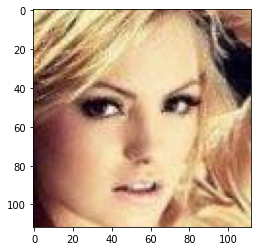

In [9]:
import numbers
import matplotlib.pyplot as plt
s = imgrec.read_idx(1)
header, img = mx.recordio.unpack(s)
label = header.label
if not isinstance(label, numbers.Number):
    label = label[0]
label = torch.tensor(label, dtype=torch.long)
sample = mx.image.imdecode(img).asnumpy()

print(label)
plt.imshow(sample)
plt.show()

In [1]:
# #extract infomation from old rec 
# s = imgrec.read_idx(0)
# header, _ = mx.recordio.unpack(s)
# if header.flag > 0:
#     header0 = (int(header.label[0]), int(header.label[1]))
#     imgidx = np.array(range(1, int(header.label[0])))
# else:
#     imgidx = np.array(list(imgrec.keys))
# print(len(imgidx))
# #write header record
# imgrec_new.write_idx(0,s)

# #write the rest records, if which record is broken, ignore it
# idx_new=1
# failed_idx=[]
# for idx in tqdm(imgidx):
#     try:
#         s = imgrec.read_idx(idx)
#         header, img = mx.recordio.unpack(s)
#         label = header.label
#         label = torch.tensor(label, dtype=torch.long)
#         sample = mx.image.imdecode(img).asnumpy()
#         if np.isnan(sample).any():
#             failed_idx.append(idx)
#             raise(Exception("nan"))
#         if sample.shape[0]<=0:
#             failed_idx.append(idx)
#             raise(Exception("nan"))
#         if np.count_nonzero(sample) <= 5:
#             failed_idx.append(idx)
#             raise(Exception("nan"))
#         # imgrec_new.write_idx(idx_new, s)
#         idx_new+=1
#     except Exception as e:
#         failed_idx.append(idx)
#         print(idx)
#         raise e
#         continue

# imgrec.close()
# imgrec_new.close()

In [ ]:
import matplotlib.pyplot as plt 

#extract infomation from old rec 
s = imgrec.read_idx(0)
header, _ = mx.recordio.unpack(s)
if header.flag > 0:
    header0 = (int(header.label[0]), int(header.label[1]))
    imgidx = np.array(range(1, int(header.label[0])))
else:
    imgidx = np.array(list(imgrec.keys))
print(len(imgidx))

#write the rest records, if which record is broken, ignore it
idx_new=1
failed_idx=[]
for idx in tqdm(imgidx[:10]):
    try:
        s = imgrec.read_idx(idx)
        header, img = mx.recordio.unpack(s)
        label = header.label
        label = torch.tensor(label, dtype=torch.long)
        sample = mx.image.imdecode(img).asnumpy()
        plt.imshow(sample)
        plt.show()
        if np.isnan(sample).any():
            failed_idx.append(idx)
            raise(Exception("nan"))
        if sample.shape[0]<=0:
            failed_idx.append(idx)
            raise(Exception("nan"))
        if np.count_nonzero(sample) <= 5:
            failed_idx.append(idx)
            raise(Exception("nan"))
        # imgrec_new.write_idx(idx_new, s)
        idx_new+=1
    except Exception as e:
        failed_idx.append(idx)
        print(idx)
        raise e

imgrec.close()

# tracking memory

In [2]:
from memory_profiler import profile
from dataset import get_dataloader
import torch
%load_ext memory_profiler

@profile
def my_func():
    train_loader = get_dataloader(
        "/mnt/data/WebFace42M_shufrec",
        0,
        48,
        False,
        1101,
        2
    )

    train_loader.sampler.set_epoch(1)

    train_iter = iter(train_loader)

    img, local_labels  = next(train_iter)



@profile
def load_dummy_data():
    a = torch.ones((1000,100))
    b = torch.ones((1000,1000))
    c = torch.ones((1000,10000))
    d = torch.ones((1000,100000))
    return


/home/thucth/.conda/envs/torch19/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%mprun -T mprof0 -f my_func my_func()

ERROR: Could not find file /tmp/ipykernel_15741/3718546178.py


*** Profile printout saved to text file mprof0. 


Filename: /home/thucth/.conda/envs/torch19/lib/python3.9/site-packages/memory_profiler.py

Line #    Mem usage    Increment  Occurrences   Line Contents
  1183    374.9 MiB    374.9 MiB           1               @wraps(wrapped=func)
  1184                                                     def wrapper(*args, **kwargs):
  1185    374.9 MiB      0.0 MiB           1                   prof = get_prof()
  1186  10765.3 MiB  10390.5 MiB           1                   val = prof(func)(*args, **kwargs)
  1187  10765.3 MiB      0.0 MiB           1                   show_results_bound(prof)
  1188  10765.3 MiB      0.0 MiB           1                   return val

: 